In [18]:
%pip install qiskit==3.12.9


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Ignored the following yanked versions: 1.2.3
ERROR: Could not find a version that satisfies the requirement qiskit==3.12.9 (from versions: 0.3.2, 0.3.3, 0.3.4, 0.3.5, 0.3.6, 0.3.7, 0.3.8, 0.3.9, 0.3.10, 0.3.11, 0.3.12, 0.3.13, 0.3.14, 0.3.15, 0.3.16, 0.4.0, 0.4.1, 0.4.2, 0.4.3, 0.4.4, 0.4.5, 0.4.6, 0.4.7, 0.4.8, 0.4.9, 0.4.10, 0.4.11, 0.4.12, 0.4.13, 0.4.14, 0.4.15, 0.5.0, 0.5.1, 0.5.2, 0.5.3, 0.5.4, 0.5.5, 0.5.6, 0.5.7, 0.6.0, 0.6.1, 0.7.0, 0.7.1, 0.7.2, 0.7.3, 0.8.0, 0.8.1, 0.9.0, 0.10.0, 0.10.1, 0.10.2, 0.10.3, 0.10.4, 0.10.5, 0.11.0, 0.11.1, 0.11.2, 0.12.0, 0.12.1, 0.12.2, 0.13.0, 0.14.0, 0.14.1, 0.15.0, 0.16.0, 0.16.1, 0.16.2, 0.17.0, 0.18.0, 0.18.1, 0.18.2, 0.18.3, 0.19.0, 0.19.1, 0.19.2, 0.19.3, 0.19.4, 0.19.5, 0.19.6, 0.20.0, 0.20.1, 0.21.0, 0.22.0, 0.23.0, 0.23.1, 0.23.2, 0.23.3, 0.23.4, 0.23.5, 0.23.6, 0.24.0, 0.24.1, 0.25.0, 0.25.1, 0.25.2, 0.25.3, 0.25.4, 0.26.0, 0.26.1, 0.26.2, 0.27.0, 0.28.0, 0.29.0, 0.29.1, 0.30.0, 0.30.1, 0.31.0, 0.32.0, 0.32.1, 0.33.0, 0.33.1, 0

Approach 1 : Classification with EstimatorQNN and PyTorch

In [19]:
import numpy as np
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit.circuit import Parameter
from matplotlib import pyplot as plt

In [20]:
%pip install time

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


In [21]:
%pip install qiskit_machine_learning

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit_machine_learning.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 12

In [ ]:
# Generate random dataset

# Select dataset dimension (num_inputs) and size (num_samples)
num_inputs = 2
num_samples = 20

# Generate random input coordinates (X) and binary labels (y)
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}, y01 will be used for SamplerQNN example
y = 2 * y01 - 1  # in {-1, +1}, y will be used for EstimatorQNN example

# Convert to torch Tensors
X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)

# Plot dataset
for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [2]:
%pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install matplotlib --upgrade


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install MatplotlibDrawer

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement MatplotlibDrawer (from versions: none)
ERROR: No matching distribution found for MatplotlibDrawer


In [ ]:
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
print(qc)

In [ ]:
# Setup QNN
qnn1 = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

# Set up PyTorch module
# Note: If we don't explicitly declare the initial weights
# they are chosen uniformly at random from [-1, 1].
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
model1 = TorchConnector(qnn1, initial_weights=initial_weights)
print("Initial weights: ", initial_weights)

In [ ]:
#single input test
model1(X_[0, :])

In [ ]:
# Define optimizer and loss
optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")

# Start training
model1.train()  # set model to training mode


# Note from (https://pytorch.org/docs/stable/optim.html):
# Some optimization algorithms such as LBFGS need to
# reevaluate the function multiple times, so you have to
# pass in a closure that allows them to recompute your model.
# The closure should clear the gradients, compute the loss,
# and return it.
def closure():
    optimizer.zero_grad()  # Initialize/clear gradients
    loss = f_loss(model1(X_), y_)  # Evaluate loss function
    loss.backward()  # Backward pass
    print(loss.item())  # Print loss
    return loss


# Run optimizer step4
optimizer.step(closure)

In [ ]:
# Evaluate model and compute accuracy
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]

print("Accuracy:", sum(y_predict == y) / len(y))

# Plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Approach 2 : PyTorch and SamplerQNN

In [ ]:
# Define feature map and ansatz
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)

# Define quantum circuit of num_qubits = input dim
# Append feature map and ansatz
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

# Define SamplerQNN and initial setup
parity = lambda x: "{:b}".format(x).count("1") % 2  # optional interpret function
output_shape = 2  # parity = 0, 1
qnn2 = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)


initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)
model2 = TorchConnector(qnn2, initial_weights)

In [ ]:
# Define model, optimizer, and loss
optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss()  # Our output will be in the [0,1] range

# Start training
model2.train()

# Define LBFGS closure method 
def closure():
    optimizer.zero_grad(set_to_none=True)  # Initialize gradient
    loss = f_loss(model2(X_), y01_)  # Calculate loss
    loss.backward()  # Backward pass

    print(loss.item())  # Print loss
    return loss


# Run optimizer (LBFGS requires closure)
optimizer.step(closure);

In [ ]:
# Evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print("Accuracy:", sum(y_predict == y01) / len(y01))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

MNIST classifier

In [18]:
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
import numpy as np # Import numpy
import matplotlib.pyplot as plt # Import matplotlib for plotting
import time # Import time to measure epoch duration

# Qiskit imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.circuit import QuantumCircuit
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

In [ ]:
# torchvision API to directly load a subset of the MNIST dataset and define torch DataLoaders (link) for train and test.

In [34]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 64 # Increased batch size for more efficient training on CPU
# Significantly increased samples for maximizing accuracy on 0s and 1s
n_samples_train_per_digit = 1500 # Increased from 1500 (total 6000 samples)

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels, leaving ONLY labels 0 and 1
idx_0 = np.where(X_train.targets == 0)[0][:n_samples_train_per_digit]
idx_1 = np.where(X_train.targets == 1)[0][:n_samples_train_per_digit]
idx = np.concatenate((idx_0, idx_1))

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

print(f"Training dataset size: {len(X_train)} (for digits 0 and 1)")

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

Training dataset size: 3000 (for digits 0 and 1)


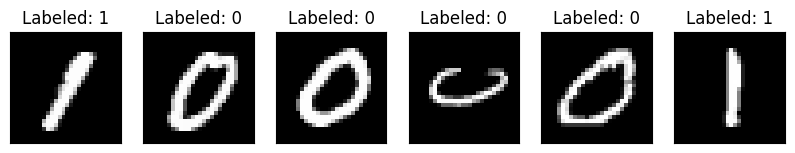

In [29]:
n_samples_show = 6

# Ensure the iterator is fresh at the start of the plotting
data_iter = iter(train_loader)

# Calculate the actual number of available batches in the DataLoader
num_batches_available = len(train_loader)

# Limit n_samples_show to the actual number of batches available
n_samples_to_plot = min(n_samples_show, num_batches_available)


fig, axes = plt.subplots(nrows=1, ncols=n_samples_to_plot, figsize=(10, 3))

for i in range(n_samples_to_plot):
    images, targets = data_iter.__next__()

    axes[i].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    axes[i].set_title("Labeled: {}".format(targets[0].item()))

plt.show()

In [35]:
# Test Dataset
# -------------

# Significantly increased samples for maximizing accuracy on 0s and 1s
n_samples_test_per_digit = 500 # Increased from 500 (total 2000 samples)

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels, leaving ONLY labels 0 and 1
idx_0 = np.where(X_test.targets == 0)[0][:n_samples_test_per_digit]
idx_1 = np.where(X_test.targets == 1)[0][:n_samples_test_per_digit]
idx = np.concatenate((idx_0, idx_1))

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

print(f"Test dataset size: {len(X_test)} (for digits 0 and 1)")

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

Test dataset size: 1000 (for digits 0 and 1)


In [ ]:
#Defining QNN and the Hybrid

In [36]:
# Define and create QNN
# We will use 2 qubits for the QNN, which can output a single value (as before).
# The classical part of the network will then expand this to 3 outputs.
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

C:\Users\claud\AppData\Local\Temp\ipykernel_16796\4141517046.py:12: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


In [37]:
# Define torch NN module
class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)
        self.qnn = TorchConnector(qnn)
        self.fc3 = Linear(1, 2) # Output layer for 2 classes (0 and 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


model4 = Net(qnn4)

In [38]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 20
loss_list = []
model4.train()

for epoch in range(epochs):
    start_time = time.time()
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        # data, target = data.to(device), target.to(device) # Removed device handling
        optimizer.zero_grad(set_to_none=True)
        output = model4(data)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss) / len(total_loss))
    end_time = time.time()
    epoch_duration = end_time - start_time
    print("Training [{:.0f}%]\tLoss: {:.4f}\tEpoch Time: {:.2f}s".format(
        100.0 * (epoch + 1) / epochs, loss_list[-1], epoch_duration))

    if epoch_duration > 60:
        print(f"Warning: Epoch {epoch+1} took {epoch_duration:.2f} seconds.")


Training [5%]	Loss: 0.6098	Epoch Time: 56.45s
Training [10%]	Loss: 0.5416	Epoch Time: 59.27s
Training [15%]	Loss: 0.4940	Epoch Time: 59.23s
Training [20%]	Loss: 0.4514	Epoch Time: 61.94s
Training [25%]	Loss: 0.4149	Epoch Time: 59.92s
Training [30%]	Loss: 0.3833	Epoch Time: 60.60s
Training [35%]	Loss: 0.3555	Epoch Time: 60.84s
Training [40%]	Loss: 0.3310	Epoch Time: 59.28s
Training [45%]	Loss: 0.3078	Epoch Time: 59.03s
Training [50%]	Loss: 0.2876	Epoch Time: 61.20s
Training [55%]	Loss: 0.2690	Epoch Time: 60.03s
Training [60%]	Loss: 0.2522	Epoch Time: 59.25s
Training [65%]	Loss: 0.2366	Epoch Time: 58.60s
Training [70%]	Loss: 0.2225	Epoch Time: 60.44s
Training [75%]	Loss: 0.2092	Epoch Time: 61.35s
Training [80%]	Loss: 0.1974	Epoch Time: 59.98s
Training [85%]	Loss: 0.1863	Epoch Time: 59.21s
Training [90%]	Loss: 0.1761	Epoch Time: 60.28s
Training [95%]	Loss: 0.1671	Epoch Time: 58.75s
Training [100%]	Loss: 0.1585	Epoch Time: 61.74s


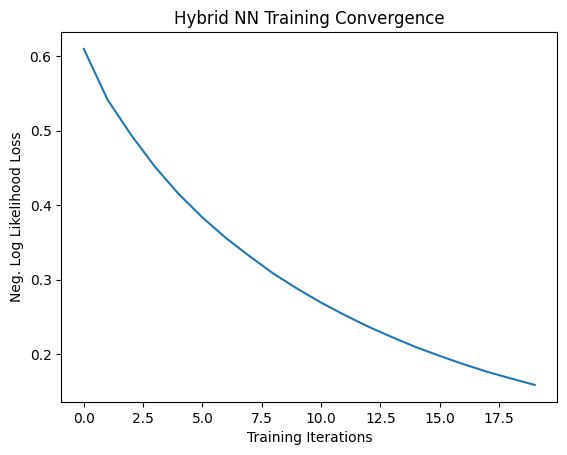

In [39]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

In [40]:
torch.save(model4.state_dict(), "model4_digits012.pt") # Changed filename

In [41]:

# to execute on real hardware, change the backend
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4_digits012.pt")) # Changed filename

model5.eval()  # set model to evaluation mode
with no_grad():
    correct = 0
    total_loss = [] # Initialize total_loss for test set
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        # NLLLoss expects log_softmax output, which already includes the log.
        # No need to use `cat((x, 1 - x), -1)` from the original 2-class setup.
        
        # The output from log_softmax will have negative values.
        # argmax will find the index of the maximum log-probability.
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader.dataset) * 100 # Corrected accuracy calculation
        )
    )


C:\Users\claud\AppData\Local\Temp\ipykernel_16796\4141517046.py:12: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(


Performance on test data:
	Loss: 0.1562
	Accuracy: 100.0%


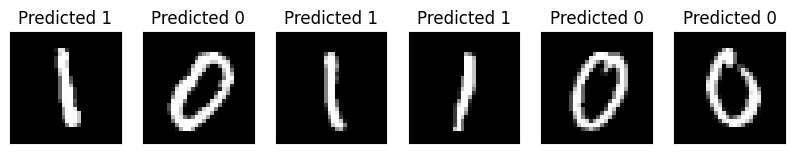

In [42]:
n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        
        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1
plt.show() # Display the plot

Repeat

In [ ]:

# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 5  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))


# to execute on real hardware, change the backend
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

In [ ]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 5  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))


# to execute on real hardware, change the backend
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

In [ ]:
print(qc)